# TP08 - Sélection de modèles

L'objectif de ce TP est de mettre en oeuvre une 
* de mesurer le risque empirique d'un modèle d'apprentissage supervisé pour différentes tailles d'échantillon (_i.e._, différentes quantités d'échantillons d'apprentissage)
* de sélectionner la valeur optimale et d'évaluer la capacité de généralisation d'un modèle d'apprentissage supervisé (classification) en utilisant 
 * un découpage en données d'apprentissage, de validation et de test 
 * le principe de la validation croisée

In [1]:
import numpy as np
import pandas as pd

import random

import seaborn as sn

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from numpy.random import randint

## Partie 1. Les données

Les données utilisées dans le cadre de ce TP sont des images de chiffres écrit manuscritement. La reconnaissance automatique de ces chiffres (et plus généralement d'écriture manuscrite) est un problème classique mais complexe. Elle est notamment utilisée dans les systsèmes de tri automatique du courrier.
Les données utilisées pour ce TP correspondent à un extrait simplifié des données MNIST (Modified National Institure of Standards and Technology) qui contient à l'origine 70 000 images de chiffres de 0 à 9. 

Chaque image (_i.e._, une observation) a une taille de 8 pix. $\times$ 8 pix. Ce qui corresponds à un vecteur composées de $d=64$ variables ($\mathbf{x}_i \in \mathbb{R}^d$ pour $1\le i\le m$).

**Note** : Les imagettes de taille de 8 pix. $\times$ 8 pix sont obtenues en applicant une réduction de dimension aux images binaires originales de taille 32 pix. $\times$ 32 pix. Les images originales ont été découpées en blocs de 4 pix. $\times$ 4 pix. (sans chevauchement). Dans chaque bloc, on a compté le nombre de "1" qui sert de nouvelles valeurs de pixel pour créer une image (non-binaire) de taille 8 pix. $\times$ 8 pix avec chaque pixel pouvant avoir une valeur comprise entre 0 et 16.

In [2]:
#-- Chargement des données
digits = datasets.load_digits()
X = digits.data
Y = digits.target
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

<Figure size 432x288 with 0 Axes>

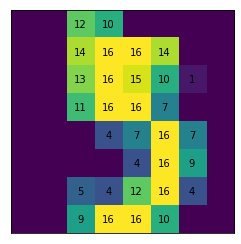

Variables:  [ 0.  0. 12. 10.  0.  0.  0.  0.  0.  0. 14. 16. 16. 14.  0.  0.  0.  0.
 13. 16. 15. 10.  1.  0.  0.  0. 11. 16. 16.  7.  0.  0.  0.  0.  0.  4.
  7. 16.  7.  0.  0.  0.  0.  0.  4. 16.  9.  0.  0.  0.  5.  4. 12. 16.
  4.  0.  0.  0.  9. 16. 16. 10.  0.  0.]
Classe asociée:  5


<Figure size 432x288 with 0 Axes>

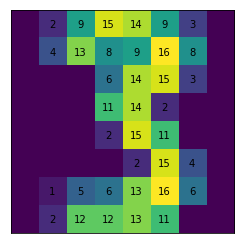

Variables:  [ 0.  2.  9. 15. 14.  9.  3.  0.  0.  4. 13.  8.  9. 16.  8.  0.  0.  0.
  0.  6. 14. 15.  3.  0.  0.  0.  0. 11. 14.  2.  0.  0.  0.  0.  0.  2.
 15. 11.  0.  0.  0.  0.  0.  0.  2. 15.  4.  0.  0.  1.  5.  6. 13. 16.
  6.  0.  0.  2. 12. 12. 13. 11.  0.  0.]
Classe asociée:  3


In [3]:
#-- Visualisation de données
disp_imgno = [5, 13] # Tester d'autres valeurs
for ll in disp_imgno:
    plt.figure()
    plt.matshow(digits.images[ll])
    for (i, j), z in np.ndenumerate(digits.images[ll]):
        if z!=0:
            plt.text(j, i, '{:d}'.format(int(z)), ha='center', va='center')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.show()
    print("Variables: ", X[ll,:])
    print("Classe asociée: ", Y[ll])

**Questions** : 
* Quel est le lien entre les images (`digit.images[ll]`) et les variables (`X[ll,:]`) + la classe associée (`Y[ll]`)? 
* Quel est le nombre de données d'apprentissage ?

X[ll,:] et digit.images[ll] correspond à l'image à la position ll qui sont respectivement non dimensionnée et dimensionnée. Y[ll] correspond à la classe associée à cette image. Si le résultat est n, alors on peut dire que l'image représente le chiffre n.

Le nombre de données d'apprentissage est la taille de digit.images : 1797.

## Partie 2. Influence de la taille de l'échantillon
L'objectif ici est d'évaluer les performances d'un algorithme de classification (risque empirique et risque réel), le $k$-Plus Proches Voisins (PPV), lorsque le nombre de données d'apprentissage augmente ($m$).

**Question** : Rappelez brièvement le principe de fonctionnement du $k$-PPV.

### 1. Risque empirique

**2.1.a** Appliquer un $k$-PPV avec $k=1$. Calculer le taux d'erreur (qui corresponds au risque empirique $\mathcal{R}_{emp}$) et expliquer le résultat.

**Astuces** : 
* Vous pouvez utiliser l'algorithme des $k$-PPV de Scikit-Learn: [doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Trouvez le nom de l'hyperparamètre qui vous permet de régler le nombre de voisins considéré lors de l'apprentissage ($k$).
* Le taux d'erreur est égal à 1 - Overall Accuracy (vous pouvez utiliser votre implémentation du TP précédent).

In [4]:
def proba_classe(y):
    return np.bincount(y) / y.shape[0]

def getConfusionMatrix(y,yhat,C=None):
    if C is None:
        C = proba_classe(y).shape[0]
    confMatrix = np.zeros((C,C))
    for i in range(y.shape[0]):
        confMatrix[y[i]][yhat[i]] += 1
    return confMatrix

def getOA(y,yhat, C=None):
    if C is None:
        C = getConfusionMatrix(y,yhat)
    return np.sum(C.diagonal()) / y.shape[0]

def sample(X,Y,size):
    x = []
    y = []
    for i in range(size):
        r = randint(X.shape[0])
        x.append(X[r,:])
        y.append(Y[r])
    x = np.asarray(x)
    y = np.asarray(y)
    return x,y

In [5]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, Y)
print("Taux d'erreur :",1 - getOA(Y, knn.predict(X)))

Taux d'erreur : 0.0


Ce taux d'erreur de 0 s'explique par le fait qu'on initialise k à 1. En effet vu qu'on utilise les mêmes échantillons pour apprendre et pour tester, l'algorithme va à chaque fois regarder l'échantillon correspondant à lui-même et donc ne produira aucune erreur.

**2.1.b** Appliquer un $k$-PPV avec $k=5$. Calculer le taux d'erreur $\mathcal{R}_{emp}$ et afficher la matrice de confusion.

**Astuce** : 
* Vous pouvez utiliser votre méthode `getConfusionMatrix()` développée au TP07, et comparer le résultat avec la matrice de confusion calculée par Scikit-Learn : `C = confusion_matrix(Y,Yhat)`.
* Pour un affichage simple de la matrice de confusion :
``` 
plt.figure()
plt.imshow(C)
plt.show()
```
* Pour un affichage plus élaboré avec Seaborn :
```
labels = data.target_names
df_cm = pd.DataFrame(C, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure()
sn.heatmap(df_cm, annot=True, fmt='d')
```

Taux d'erreur : 0.009460211463550361


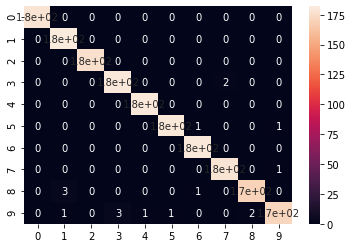

In [6]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, Y)
yhat = knn.predict(X)
c = getConfusionMatrix(Y,yhat)
print("Taux d'erreur :",1 - getOA(Y,yhat,C=c))

labels = digits.target_names.astype(np.int32)
df_cm = pd.DataFrame(c, index = [i for i in labels],
                columns = [i for i in labels])
plt.figure()
sn.heatmap(df_cm, annot=True)

**2.1.c** Tracer l'évolution du risque empririque, pour $k=5$, en fonction de la taille des données d'apprentissage.
* Définir les différentes tailles d'apprentissage : `size = [5, 10, 25, 50, 75, 100, 150, 200, 250, 500, 1000, 1500]`.
* Tirer un échantillon aléatoire de la taille donnée.
Note : il est possible d'utiliser la méthode `random.sample` du module `random`.
* Applicquer un $5$-PPV pour chaque taille d'échantillon et calculer $\mathcal{R}_{emp}$ le risque empirique.
* Tracer l'évolution du risque empirique en fonction de la taille de l'échantillon : $\mathcal{R}_{emp}=f(size)$.

**Commenter**

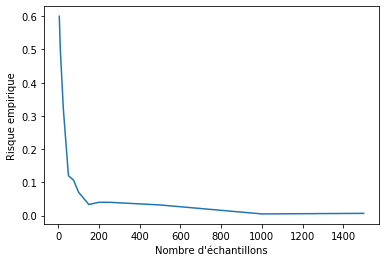

In [42]:
size = [5, 10, 25, 50, 75, 100, 150, 200, 250, 500, 1000, 1500]
res1 = []
knn = KNeighborsClassifier(n_neighbors=5)
for i in size:
    x, y = sample(X,Y,i)
    knn.fit(x, y)
    res1.append(1-getOA(y, knn.predict(x)))
plt.figure()
plt.plot(size,res1)
plt.xlabel("Nombre d'échantillons")
plt.ylabel("Risque empirique")
plt.show()

### 2. Risque réel et erreur de généralisation, $k$ fixé

**2.2.a** Calculer une estimation de l'erreur de généralisation en utilisant un jeu d'apprentissage et de test ($N=297$), pour les différentes tailles d'échantillons d'apprentissage testées ci-dessus (size), et toujours en considérant un $5$-PPV.
* Diviser aléatoirement les échantillons en sous-ensembles d'apprentissage  et de test : ` Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size=N)` avec `N` la taille de l'échantillon de test désirée.
* Superposer les deux courbes d'évolution du risque empirique et du risque réel en fonction de la taille de l'échantillon d'apprentissage. N'hésitez pas à aussi visualiser les courbes uniquement pour les plus grandes tailles d'échantillon d'apprentissage.

**Comparer et commenter**

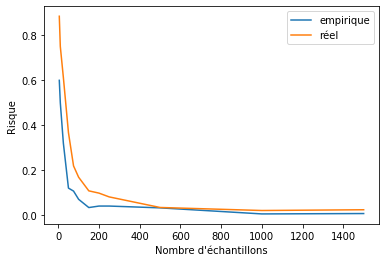

In [43]:
N = 297
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size=N)
knn = KNeighborsClassifier(n_neighbors=5)
res2 = []
for i in size:
    x, y = sample(Xtrain,Ytrain,i)
    knn.fit(x, y)
    res2.append(1-getOA(Ytest, knn.predict(Xtest)))

plt.figure()
plt.plot(size,res1, label="empirique")
plt.plot(size,res2, label="réel")
plt.legend(loc="upper right")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("Risque")
plt.show()

**2.2.b** Jusqu'à présent les résultats sont obtenus pour une seule répétition alors que les résultats dépendent du découpage entre les données d'apprentissage et de test. Généralement cette procédure est répétée plusieurs fois afin d'obtenir la moyenne et la variance des résultats.

Répéter la procédure précédente (2.2.a) 20 fois, et calculer les risques empirique et réel moyens, ainsi que les variances associées. Comparer les résultats avec ceux obtenus sur une seule répétition.

**Astuce** : vous pouvez afficher les résultats avec plt.errorbar() pour afficher la courbe +/- un écart-type

**Commenter**

In [17]:
#-- Calculer pour 20 runs

rEmp = []
rReal = []
for i in range(20):
    resEmp = []
    resReal = []
    for j in size:
        x, y = sample(X,Y,j)
        knn.fit(x, y)
        resEmp.append(1-getOA(y, knn.predict(x)))
        x, y = sample(Xtrain,Ytrain,j)
        knn.fit(x, y)
        resReal.append(1-getOA(Ytest, knn.predict(Xtest)))
    rEmp.append(resEmp)
    rReal.append(resReal)
    

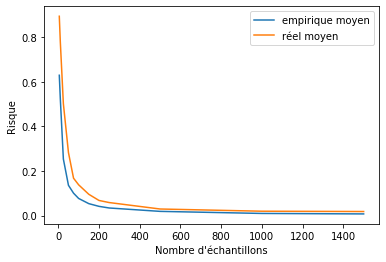

In [28]:
#-- Affichage des résultats
plt.figure()
plt.plot(size,np.mean(rEmp, axis=0), label="empirique moyen")
plt.plot(size,np.mean(rReal, axis=0), label="réel moyen")
plt.legend(loc="upper right")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("Risque")
plt.show()

**2.2.c** Mettre en oeuvre une validation croisée sur 5 sous-ensembles / partitions (*$5$-fold cross validation*) sur l'ensemble des données d'apprentissage (toujours avec le $5$-PPV). Donner une estimation de l'erreur de généralisation : `scores = cross_val_score(knn, X, Y, cv=5)` [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score#sklearn.model_selection.cross_val_score).

**Question** : Quelle est la valeur moyenne d'Overall Accuracy que vous obtenez ?

In [33]:
scores = cross_val_score(knn, X, Y, cv=5)
print("Erreur :",1-np.mean(scores))
OA = []
for i in range(20):
    OA.append(getOA(Y,knn.predict(X)))
print("Moyenne OA :",np.mean(OA))

Erreur : 0.03727174249458387
Moyenne OA : 0.9816360601001671


## Partie 3. Choix du meilleur hyperparamètre $k$ (du $k$-PPV) et estimation des performances en généralisation

L'objectif de cette partie est de déterminer la meilleure valeur de l'hyperparamètre $k$ de l'algorithme PPV et d'évaluer les performances de généralisation.

**3.1** Tracer l'évolution du risque empirique pour $k\in [1,30]$. **Commenter**

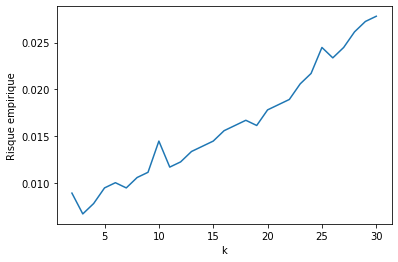

In [66]:
rEmp = []
size = range(2,31)
for i in size:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X,Y)
    rEmp.append(1-getOA(Y, knn.predict(X)))

plt.figure()
plt.plot(size,rEmp)
plt.xlabel("k")
plt.ylabel("Risque empirique")
plt.show()

La valeur de k qui offre un risque empirique le moins élevé semble être 3

**3.2** Créer un jeu d'apprentissage qui contient 80 % des données. Les 20 % restantes seront les données de test.

In [44]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size=0.2)

**3.3** Pour $k\in [1,30]$, réaliser une validation croisée sur 5 sous-ensembles (*$5$-fold cross-validation*) sur le jeu de données d'apprentissage. Le même jeu de donnée d'apprentissage sera considéré.

In [58]:
err = 1
k = 0
size = range(2,31)
for i in size:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(Xtrain,Ytrain)
    scores = cross_val_score(knn, Xtrain, Ytrain, cv=5)
    error = 1-np.mean(scores)
    if error <= err:
        err = error
        k  = i

print("K choisi :",k )

K choisi : 5


**3.4** Quelle est la meilleure valeur de $k$ à choisir ?

**3.5** Pour cette valeur de $k$ optimale, donner une estimation du risque réel. La phase d'apprentissage sera réalisée sur l'ensemble des données d'apprentissage.

In [61]:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(Xtrain,Ytrain)
Yhat = knn.predict(Xtest)
print("Risque réel : ", 1-getOA(Ytest, Yhat))

Risque réel :  0.005555555555555536


**3.6** Calculer la matrice de confusion du modèle. Que pensez vous de ce modèle ?

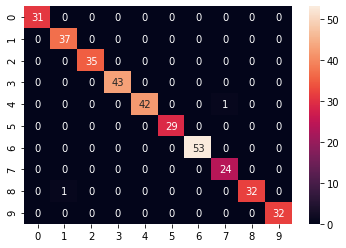

In [62]:
C = confusion_matrix(Ytest,Yhat)

labels = digits.target_names.astype(np.int32)
df_cm = pd.DataFrame(C, index = [i for i in labels],
                columns = [i for i in labels])
plt.figure()
sn.heatmap(df_cm, annot=True)

D'après les résultats, le modèle semble très fiable.

**3.7** Finalement, donner une estimation du risque réel en répétant 10 fois l'expérience précédente.

Quelle est la valeur du risque réel moyen que vous obtenez ?

In [64]:
rReal = []
for i in range(10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain,Ytrain)
    rReal.append(1-getOA(Ytest, knn.predict(Xtest)))
print("Valeur moyenne du risque réel :",np.mean(rReal))

Valeur moyenne du risque réel : 0.005555555555555536
